In [1]:
from matplotlib import pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
from libVersion2 import *

import scipy.io as scio
import scipy
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import cartopy.crs as ccrs

In [2]:
def extractValues(df, col_name):
    if col_name not in df.columns:
        return []
    else:
        return df[col_name].values[1:].astype(float)
    # df['']提取series中的列，.values转化为ndarray，.astype(float)转化为float
    # ndarray第0位为列名，从第1位开始取
    
def plotMixInd(R, k):
    if len(R.Lsfun) == 0:
        return []
    num_time_steps = R.Lsfun.shape[1]
    mixing_indices = np.zeros(num_time_steps)    
    phi = R.Lsfun[:, 0]
    integral0 = np.sum(phi)
    infarray = np.ones(R.Lsfun.shape[0]) * k
    integralInf = np.sum(infarray)
    for i in range(num_time_steps):
    # 存储混合指数
        mixing_indices[i] = (integral0 - np.sum(R.Lsfun[:, i])) / (integral0 - integralInf)
    return mixing_indices

def plotMixIndbyVf(R, k):
    if len(R.Vf) == 0:
        return []
    num_time_steps = R.Vf.shape[1]
    mixing_indices = np.zeros(num_time_steps)    
    phi = R.Vf[:, 0]
    integral0 = np.sum(phi)
    infarray = np.ones(R.Vf.shape[0]) * k
    integralInf = np.sum(infarray)
    for i in range(num_time_steps):
    # 存储混合指数
        mixing_indices[i] = (integral0 - np.sum(R.Vf[:, i])) / (integral0 - integralInf)
    return mixing_indices

def normalize_data(data):
    return (data - np.min(data)) / (np.max(data)*1.1 - np.min(data))

def merge_points_by_y(y_arr, value_arr):
    """
    将相同y坐标上的点合并,值取平均

    参数:
        y_arr (numpy.ndarray): y坐标数组
        value_arr (numpy.ndarray): 值数组

    返回:
        merged_points (list): 包含(y, avg_value)元组的列表
    """
    # 使用numpy.unique获取唯一的y坐标
    unique_y = np.unique(y_arr)

    # 初始化一个空列表用于存储合并后的点
    merged_points = []

    # 遍历每个唯一的y坐标
    for y in unique_y:
        # 找到y_arr中等于y的索引
        indices = np.where(y_arr == y)[0]
        
        # 获取对应的值
        values = value_arr[indices]
        
        # 计算平均值
        avg_value = np.mean(values)
        
        # 将(y, avg_value)元组添加到merged_points列表
        merged_points.append((y, avg_value))

    return merged_points

def truncatedArray(scatter_x):
    for i in range(len(scatter_x)):
        scatter_x[i] = round(scatter_x[i], 1)
    return scatter_x

def split_merged_points(merged_points):
    """
    将合并后的点分割为两个数组

    参数:
        merged_points (list): 包含(y, avg_value)元组的列表

    返回:
        y (numpy.ndarray): y坐标数组
        avg_value (numpy.ndarray): 平均值数组
    """
    # 使用列表解析从元组中提取y坐标和平均值
    y = np.array([y_coord for y_coord, _ in merged_points])
    avg_value = np.array([avg_val for _, avg_val in merged_points])

    return y, avg_value

def data2matrix2(x_grid, y_grid, data):
    target_x, target_y = np.meshgrid(
        np.arange(0, 0.095, 0.0005),
        np.arange(0, 0.042, 0.0005),
    )
    # 生成坐标点对
    points = np.column_stack((x_grid, y_grid))
    for i in range(data.shape[1]):  # 按列循环
        if i == 0:
            matrixAll = griddata(points, data[:, i], (target_x, target_y), method='nearest')
        else:
            matrix = griddata(points, data[:, i], (target_x, target_y), method='nearest')
            matrixAll = np.dstack((matrixAll, matrix))

    return matrixAll

def setClim(vort):
    cmin = -np.min((np.abs(np.min(vort)), np.max(vort)))#.astype(int)
    cmax = np.min((np.abs(np.min(vort)), np.max(vort)))#.astype(int)
    caxis_range = [cmin, cmax]
    plt.clim(caxis_range[0], caxis_range[1])
    return caxis_range

def calDMD(data, k):
    UX = data[:, k:data.shape[1]-1]
    UY = data[:, k+1:data.shape[1]] # 舍去前k个snapshot 0.001 * 10 * k = 0.01 * k s 
    Dd, b, Phi, Time_DMD, Energy = DMD_class(UX, UY)
    return Dd, b, Phi, Time_DMD, Energy

In [3]:
class RamMixSnap(object): # 以每一帧数据作为操作对象
    def __init__(self, dfpath):
        self.df = pd.read_table(dfpath, header=None, sep='\s+', engine='python', skipinitialspace=True)
        self.df.columns = self.df.iloc[0] # 列名
        self.x_grid = extractValues(self.df, 'x-coordinate') # x坐标位置（物理）
        self.y_grid = extractValues(self.df, 'y-coordinate') # y坐标位置 （物理）
        
        self.vf = extractValues(self.df, 'gly-vof') # 体积函数    
        self.vx = extractValues(self.df, 'velocity-magnitude') * np.cos(extractValues(self.df, 'velocity-angle')) # 从速度大小和角度中恢复x方向速度
        self.vy = extractValues(self.df, 'velocity-magnitude') * np.sin(extractValues(self.df, 'velocity-angle')) # 从速度大小和角度中恢复y方向速度
        self.vaxial = extractValues(self.df, 'axial-velocity') # 轴向加速度
        self.vradial = extractValues(self.df, 'radial-velocity') # 径向加速度
        self.vort = extractValues(self.df, 'vorticity-mag') # 涡度
        self.turIntensity = extractValues(self.df, 'turb-intensity') # 湍流强度
        self.lsfun = extractValues(self.df, 'lsfun') # 水平集函数

class RamMix(object): # 以每一种仿真配置作为对象
    def __init__(self, dirpath):
        self.dirpath = dirpath # 目标文件夹
        self.file_list = [] # 文件夹遍历文件路径
        self.get_file_list()
        
        self.x_grid = [] 
        self.y_grid = []
        self.Vx = [] # x方向速度数据集合
        self.Vy = [] # v方向速度数据集合
        self.Vaxial = [] # 轴向速度数据集合
        self.Vradial = [] # 径向速度数据集合
        self.Vort = [] # 涡度数据集合
        self.Vf = [] # 体积函数数据集合
        self.TurIntensity = [] # 湍流强度数据集合
        self.Lsfun = [] # 水平集函数数据集合
        self.get_data()
        
        self.indexp = []
        self.plot_exp_curve(0.9)
        
        self.Dd = [-1 for _ in range(4)] 
        self.b = [-1 for _ in range(4)] 
        self.Phi = [-1 for _ in range(4)] 
        self.Time_DMD = [-1 for _ in range(4)]
        self.Energy = [-1 for _ in range(4)]
        
        self.U0x_pod = [-1 for _ in range(4)] 
        self.An_pod = [-1 for _ in range(4)] 
        self.PhiU_pod = [-1 for _ in range(4)] 
        self.Ds_pod = [-1 for _ in range(4)]
        
        self.get_result(0)
        
        

    def get_file_list(self):
        if self.dirpath is None:
            print('文件夹路径为空')
        for root, dirs, files in os.walk(self.dirpath):
            for file_name in files:
                file_path = os.path.join(root, file_name)
                self.file_list.append(file_path)
                
    def get_data(self):
        for i, file_name in enumerate(self.file_list):
            if file_name:
                ramsnap = RamMixSnap(file_name)
            else:
                print('第{}个文件为空'.format(i))
            if not i:
                self.x_grid = ramsnap.x_grid
                self.y_grid = ramsnap.y_grid
                self.Vx = ramsnap.vx
                self.Vy = ramsnap.vy
                self.Vaxial = ramsnap.vaxial
                self.Vradial = ramsnap.vradial
                self.Vort = ramsnap.vort
                self.Vf = ramsnap.vf
                self.TurIntensity = ramsnap.turIntensity
                self.Lsfun = ramsnap.lsfun
            else:
                self.Vx = np.column_stack((self.Vx, ramsnap.vx))
                self.Vy = np.column_stack((self.Vy, ramsnap.vy))
                self.Vaxial = np.column_stack((self.Vaxial, ramsnap.vaxial))
                self.Vradial = np.column_stack((self.Vradial, ramsnap.vradial))
                self.Vort = np.column_stack((self.Vort, ramsnap.vort))
                self.Vf = np.column_stack((self.Vf, ramsnap.vf))
                self.TurIntensity = np.column_stack((self.TurIntensity, ramsnap.turIntensity))
                self.Lsfun = np.column_stack((self.Lsfun, ramsnap.lsfun))
                
    def plot_exp_curve(self, k):
        self.indexp = plotMixInd(self, k)
        
    def data2matrix(self, data):
        return data2matrix2(self.x_grid, self.y_grid, data)
        
    def data_prepare(self):
        U_xt = Uxyt2Uxt(self.data2matrix(self.Vx))
        V_xt = Uxyt2Uxt(self.data2matrix(self.Vy))
        UV_xt = np.vstack((U_xt*1000, V_xt*1000))
        Vort_xt = Uxyt2Uxt(self.data2matrix(self.Vort))
        return UV_xt, Vort_xt
    
    def dmd(self, Data):
        Dd, b, Phi, Time_DMD, Energy = calDMD(Data, k=5)
        return Dd, b, Phi, Time_DMD, Energy
    
    def pod(self, Data):
        U0x_pod, An_pod, PhiU_pod, Ds_pod = pod_svd(Data.T)
        return U0x_pod, An_pod, PhiU_pod, Ds_pod
    
    def get_result(self, k):
        from libVersion2 import DMD_class, pod_svd
        UV_xt, Vort_xt = self.data_prepare()
        self.Dd[0], self.b[0], self.Phi[0], self.Time_DMD[0], self.Energy[0] = self.dmd(UV_xt)
        self.U0x_pod[0], self.An_pod[0], self.PhiU_pod[0], self.Ds_pod[0] = self.pod(UV_xt)
        
        self.Dd[1], self.b[1], self.Phi[1], self.Time_DMD[1], self.Energy[1] = self.dmd(Vort_xt)
        self.U0x_pod[1], self.An_pod[1], self.PhiU_pod[1], self.Ds_pod[1] = self.pod(Vort_xt)

In [4]:
dirpath = ['dataset/0331/S20gf10F70/ascii',
           'dataset/0331/S30gf10F70/ascii',
           'dataset/0331/S40gf10F70/ascii',
           'dataset/0331/S50gf10F70/ascii']
R1 = RamMix(dirpath[0])
R2 = RamMix(dirpath[1])
R3 = RamMix(dirpath[2])
R4 = RamMix(dirpath[3])

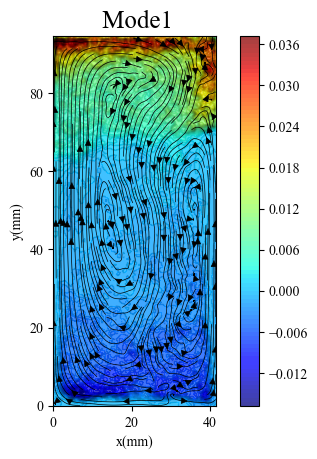

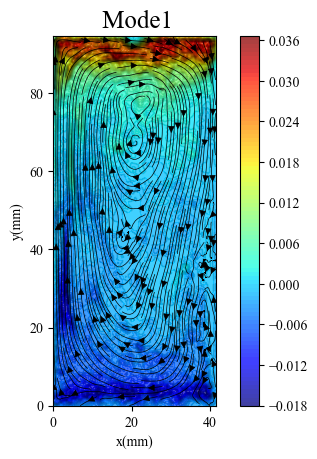

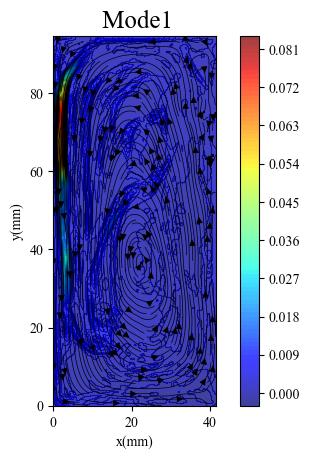

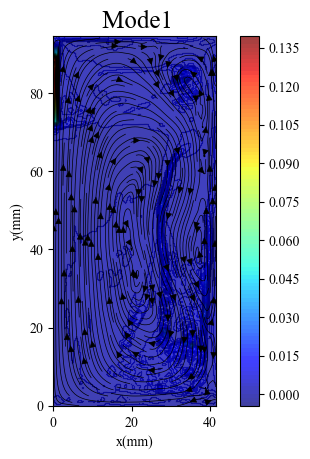

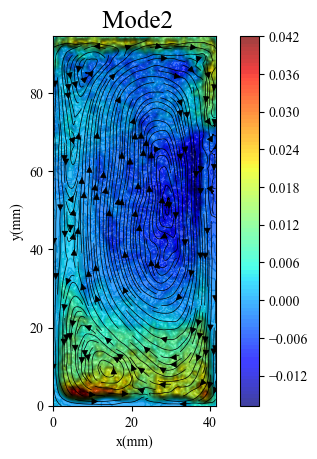

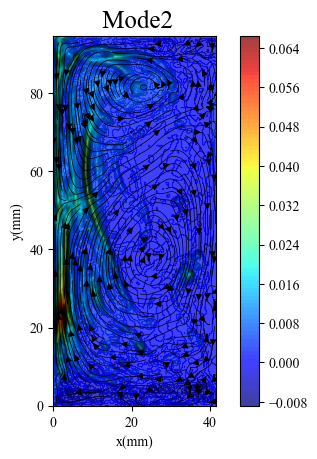

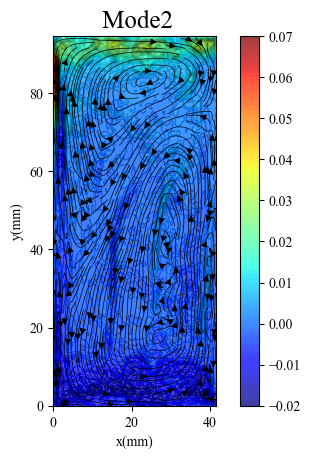

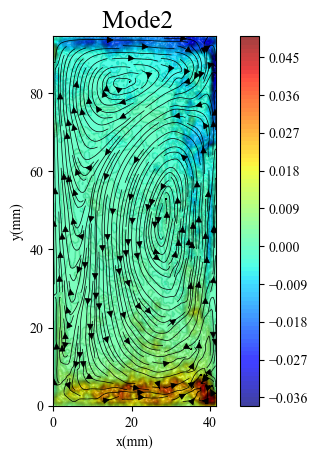

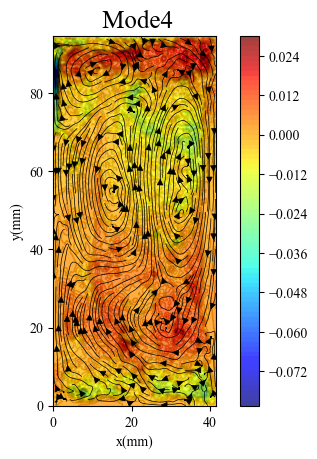

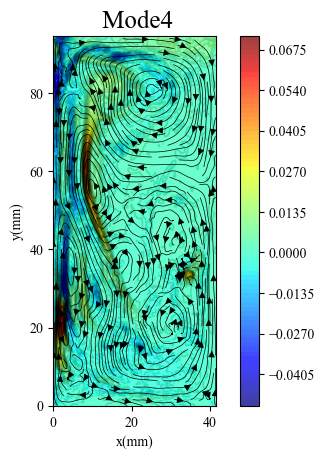

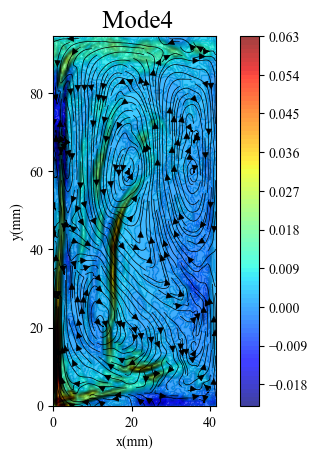

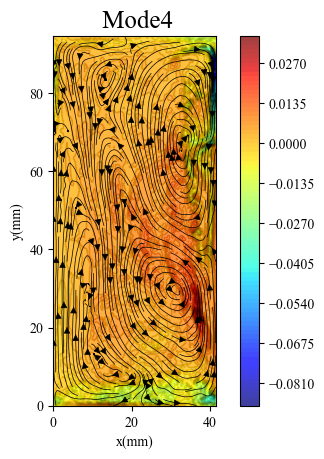

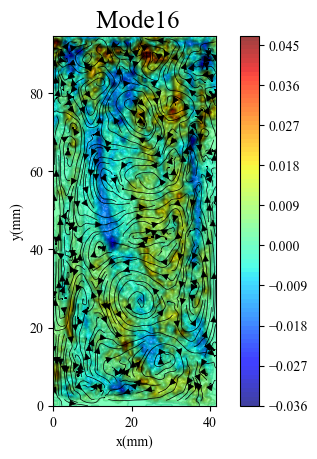

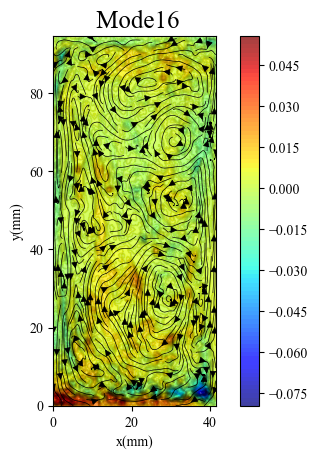

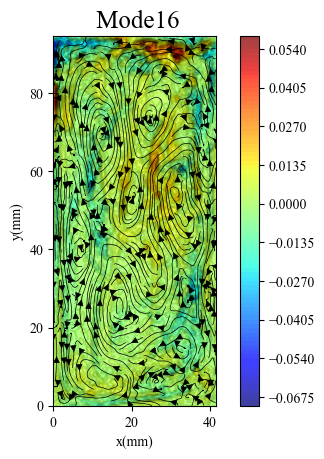

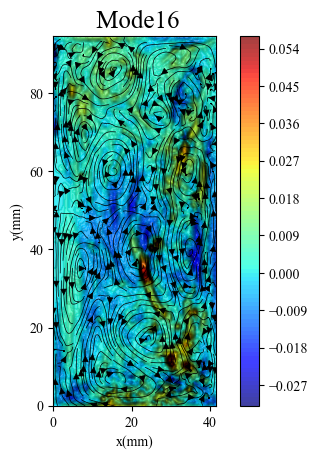

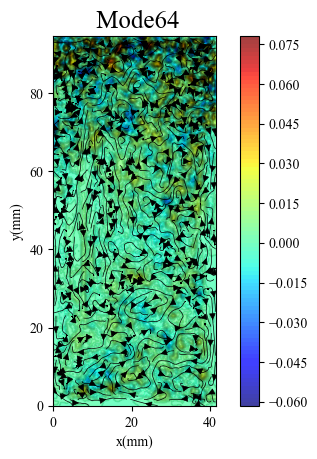

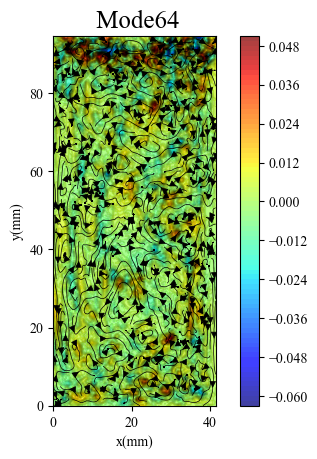

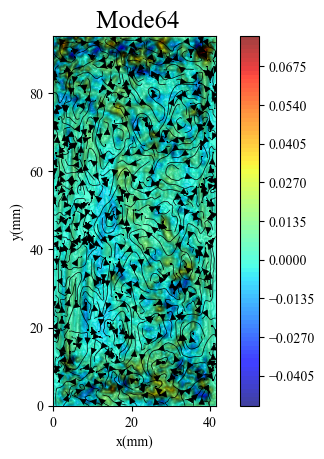

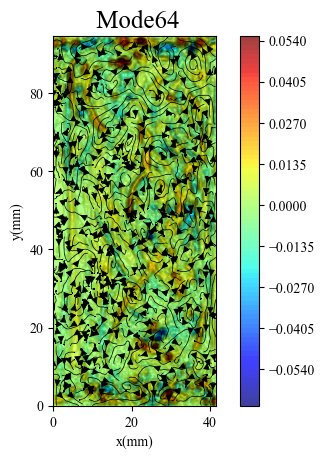

In [5]:
# 提取POD模态
x_coords = np.arange(0, 95, 0.5)
y_coords = np.arange(0, 42, 0.5)
X, Y = np.meshgrid(x_coords, y_coords)
Nx = len(x_coords)
Ny = len(y_coords)
def plotPODStreamlines(PhiU, k=0):
    Uxyi, Vxyi = UV2UxyVxy(PhiU[:, k], Ny, Nx)
    plt.streamplot(y_coords, x_coords, Vxyi.T, Uxyi.T, density=2, color='black', linewidth=0.5)
    plt.rcParams['font.sans-serif'] = ['Times New Roman']
    plt.title(" Mode"+str(k+1), fontsize=18)
#     plt.text(0.7, 0.7, 'Vort')
    plt.xlim(0)
    plt.xlabel('x(mm)')
    plt.ylim(0)
    plt.ylabel('y(mm)')
    plt.gca().set_aspect('equal', adjustable='box')# x\y轴比例相等
def plotPODcontourf(PhiU, k=0):
#     Uxyi, Vxyi = UV2UxyVxy(PhiU[:, k], Ny, Nx)
    con = plt.contour(Y, X,
#                       curl(Uxyi*1000, Vxyi*1000),
                      PhiU[:, k].reshape(Ny, Nx),
                      100, 
                      colors='black',
                      alpha=0.1
                     )
    plt.contourf(Y, X, 
#                 curl(Uxyi*1000, Vxyi*1000),
                 PhiU[:, k].reshape(Ny, Nx),
                 100, 
                 cmap='jet',
                 alpha=0.75)
    cbar = plt.colorbar( )
  
    
for i, k in enumerate([0, 1, 3, 15, 63]):
    plotPODStreamlines(R1.PhiU_pod[0], k)
    plotPODcontourf(R1.PhiU_pod[1], k)
    plt.savefig("results/plot/acc/new_POD_S20gf40F70_"+str(k+1)+"streamplot_contourtest.png", dpi=300)
    plt.show()
    plotPODStreamlines(R2.PhiU_pod[0], k)
    plotPODcontourf(R2.PhiU_pod[1], k)
    plt.savefig("results/plot/acc/new_POD_S30gf40F70_"+str(k+1)+"streamplot_contourtest.png", dpi=300)
    plt.show()
    plotPODStreamlines(R3.PhiU_pod[0], k)
    plotPODcontourf(R3.PhiU_pod[1], k)
    plt.savefig("results/plot/acc/new_POD_S40gf40F70_"+str(k+1)+"streamplot_contourtest.png", dpi=300)
    plt.show()
    plotPODStreamlines(R4.PhiU_pod[0], k)
    plotPODcontourf(R4.PhiU_pod[1], k)
    plt.savefig("results/plot/acc/new_POD_S50gf40F70_"+str(k+1)+"streamplot_contourtest.png", dpi=300)
    plt.show()

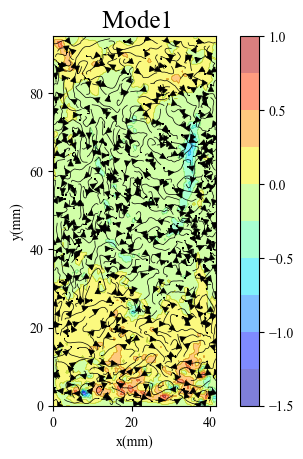

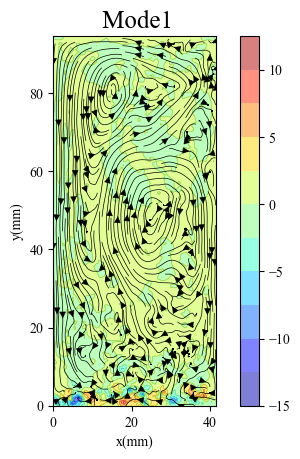

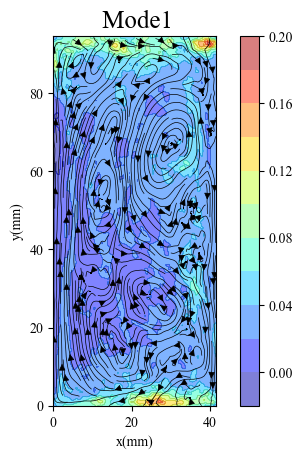

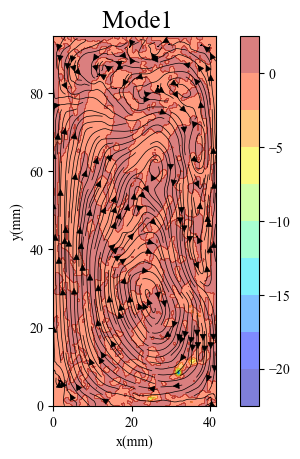

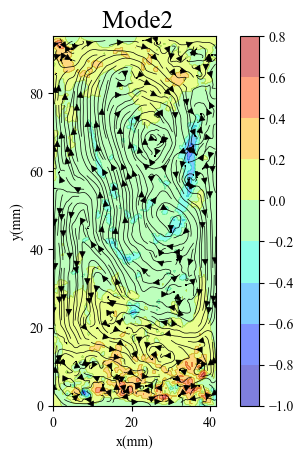

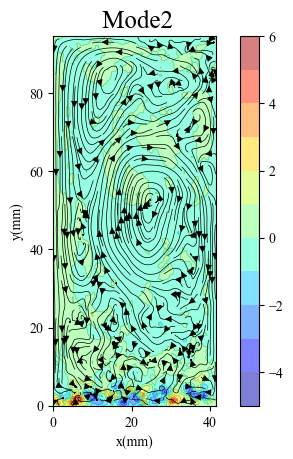

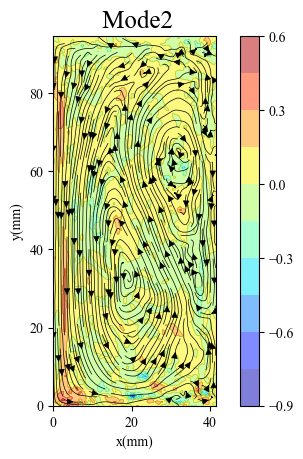

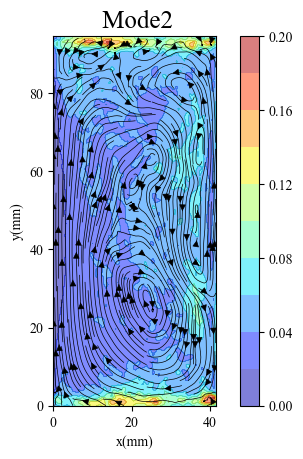

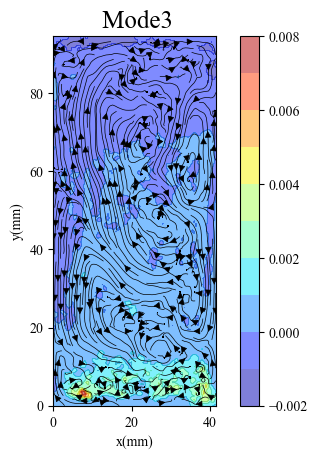

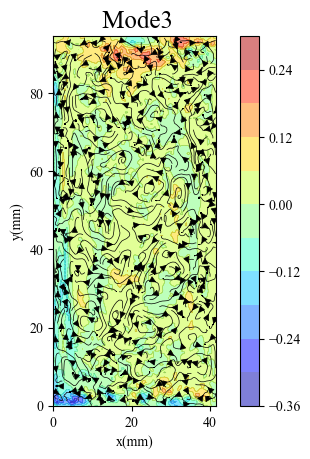

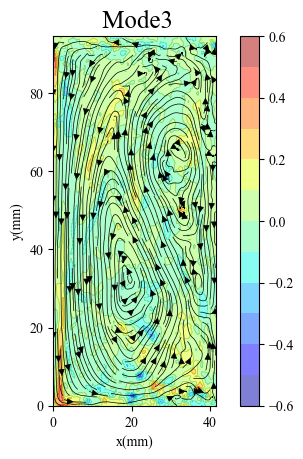

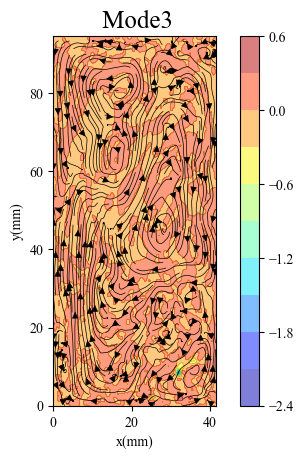

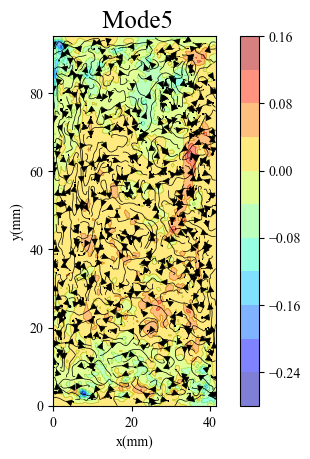

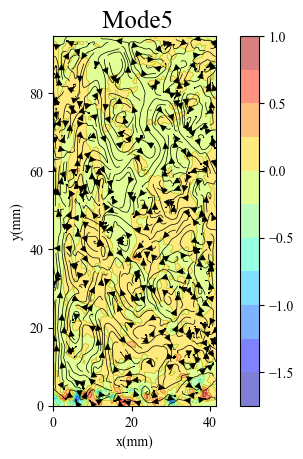

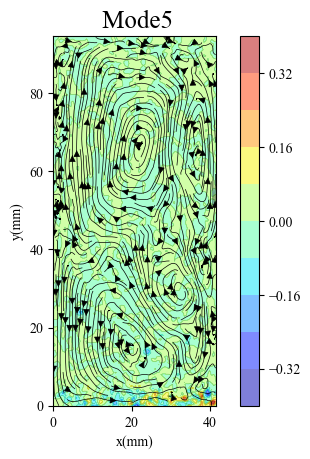

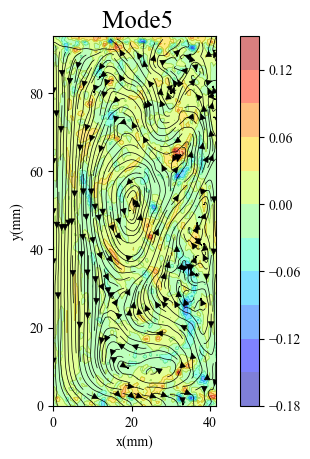

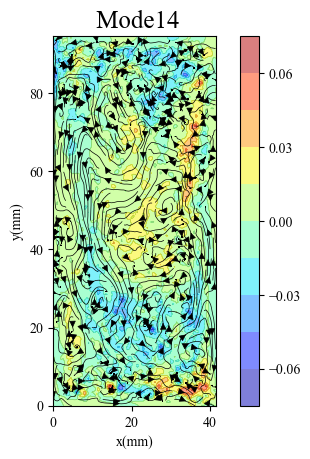

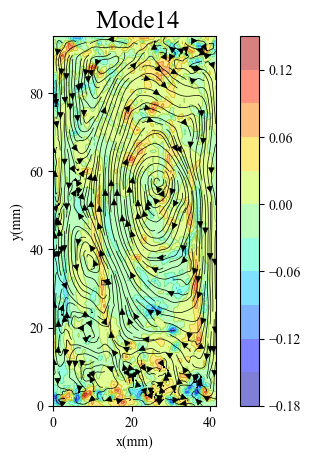

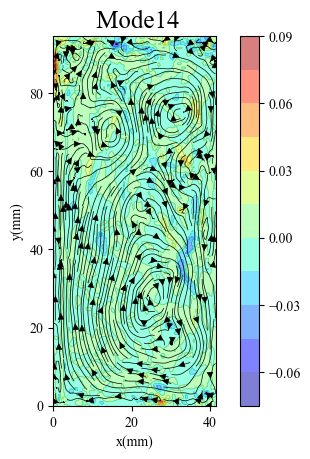

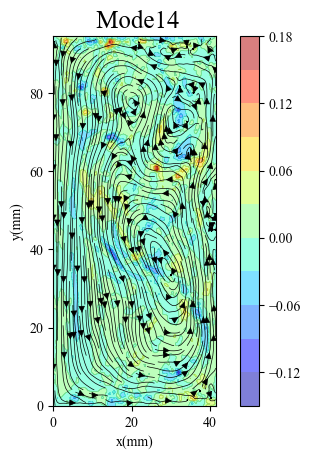

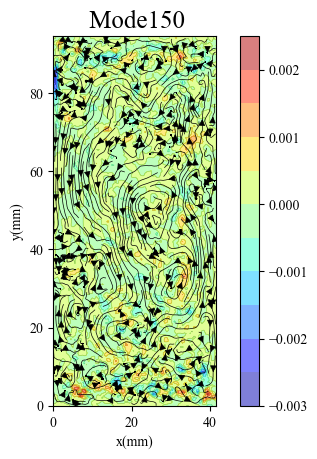

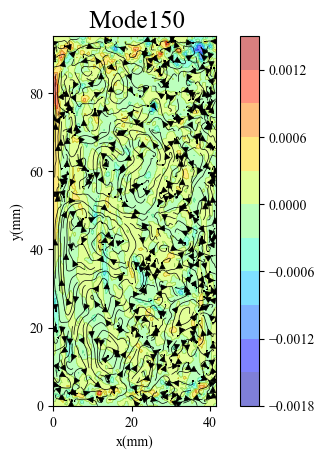

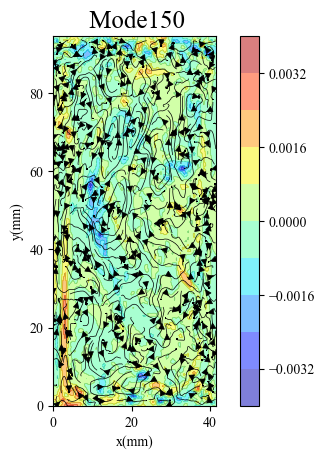

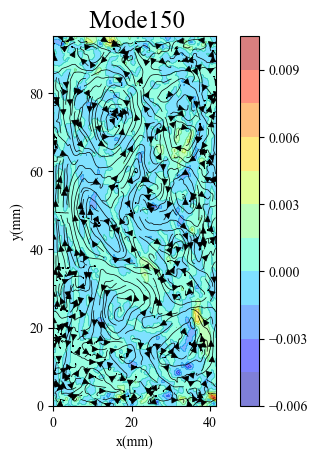

In [6]:
def plotDMDStreamlines(Phi, Time_DMD, k=0):
    Uxt_DMD_k = np.real(np.outer(Phi[:, k], Time_DMD[k, :]))
    Uxyk, Vxyk = UV2UxyVxy(Uxt_DMD_k[:, k], Ny, Nx)
    plt.streamplot(y_coords, x_coords, Vxyk.T, Uxyk.T, density=2, color='black', linewidth=0.5)
    plt.rcParams['font.sans-serif'] = ['Times New Roman']
    plt.title(" Mode"+str(k+1), fontsize=18)

def plotDMDContourfUV(Phi, Time_DMD, k=0):
    Uxt_DMD_k = np.real(np.outer(Phi[:, k], Time_DMD[k, :]))
    Uxyk, Vxyk = UV2UxyVxy(Uxt_DMD_k[:, k], Ny, Nx)
    contourlineNum = 10
    con = plt.contour(Y, X,
                      curl(Uxyk, Vxyk)/1000,
                      contourlineNum,
                      colors='black',
                      alpha=0.2,
                      linewidths=0.5)
    plt.contourf(Y, X,
                 curl(Uxyk, Vxyk)/1000,
                 contourlineNum,
                 cmap='jet',
                 alpha=0.5)
    plt.colorbar()
    plt.xlim(0)
    plt.ylim(0)
    plt.gca().set_aspect('equal', adjustable='box')# x\y轴比例相等
    
def plotDMDContourf(Phi, Time_DMD, k=0):
    Uxt_DMD_k = np.real(np.outer(Phi[:, k], Time_DMD[k, :]))
    contourlineNum = 10
    con = plt.contour(Y, X,
                      Uxt_DMD_k[:, k].reshape(Ny, Nx)/10000,
                      contourlineNum,
                      colors='black',
                      alpha=0.2,
                      linewidths=0.5)
    plt.contourf(Y, X,
                 Uxt_DMD_k[:, k].reshape(Ny, Nx)/10000,
                 contourlineNum,
                 cmap='jet',
                 alpha=0.5)
    plt.colorbar()
    plt.xlim(0)
    plt.xlabel('x(mm)')
    plt.ylim(0)
    plt.ylabel('y(mm)')
    plt.gca().set_aspect('equal', adjustable='box')# x\y轴比例相等
    
for i, k in enumerate([0, 1, 2, 4, 13, 149]):
    plotDMDStreamlines(R1.Phi[0], R1.Time_DMD[0], k)
    plotDMDContourf(R1.Phi[1], R1.Time_DMD[1], k)
    plt.savefig("results/plot/acc/new_DMD_S20gf10F70_"+str(k+1)+"streamplot_contourtest.png", dpi=300)
    plt.show()
    plotDMDStreamlines(R2.Phi[0], R2.Time_DMD[0], k)
    plotDMDContourf(R2.Phi[1], R2.Time_DMD[1], k)
    plt.savefig("results/plot/acc/new_DMD_S30gf10F70_"+str(k+1)+"streamplot_contourtest.png", dpi=300)
    plt.show()
    plotDMDStreamlines(R3.Phi[0], R3.Time_DMD[0], k)
    plotDMDContourf(R3.Phi[1], R3.Time_DMD[1], k)
    plt.savefig("results/plot/acc/new_DMD_S40gf10F70_"+str(k+1)+"streamplot_contourtest.png", dpi=300)
    plt.show()
    plotDMDStreamlines(R4.Phi[0], R4.Time_DMD[0], k)
    plotDMDContourf(R4.Phi[1], R4.Time_DMD[1], k)
    plt.savefig("results/plot/acc/new_DMD_S50gf10F70_"+str(k+1)+"streamplot_contourtest.png", dpi=300)
    plt.show()

In [7]:
Rexp20gf40 = RamMix('dataset/0306/glyS20gf40F70/ascii')

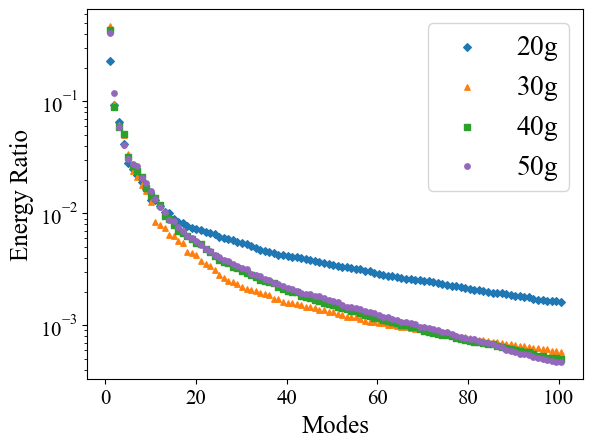

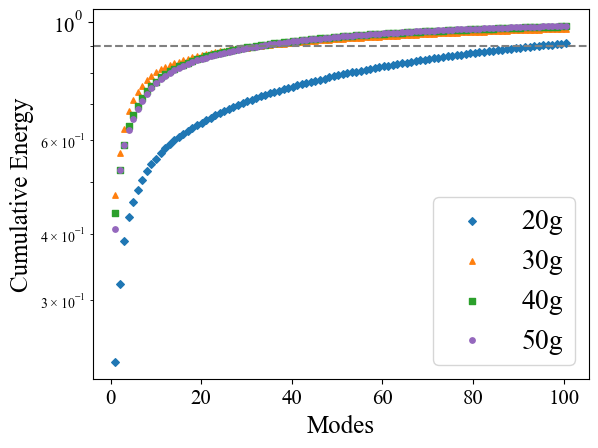

In [17]:
def normalize(Energy):
#     Energy_N = (Energy - np.min(Energy)) / (np.max(Energy) - np.min(Energy))
    Energy_N = Energy / np.max(Energy)
    return Energy_N

def calNormalizedEnergy(Ds):
    Ds_N = np.sum(Ds / np.sum(Ds), axis=1)
#     Ds_N = normalize(Ds_N)
    cum_Ds_N = np.cumsum(Ds_N)
    return Ds_N, cum_Ds_N
colors = [
    '#1F77B4',  # 蓝色
    '#FF7F0E',  # 橙色
    '#2CA02C',  # 绿色
    '#9467BD'   # 紫色
]

Ds_N_20g, cum_Ds_N_20g = calNormalizedEnergy(R1.Ds_pod[0])
Ds_N_30g, cum_Ds_N_30g = calNormalizedEnergy(R2.Ds_pod[0])
Ds_N_40g, cum_Ds_N_40g = calNormalizedEnergy(R3.Ds_pod[0])
Ds_N_50g, cum_Ds_N_50g = calNormalizedEnergy(R4.Ds_pod[0])
modes = np.linspace(0, len(Ds_N_20g), len(Ds_N_20g))

fig = plt.figure()
k = 100
usrmarkersize=15
R1_20g = plt.scatter(modes[0:k]+1, Ds_N_20g[0:k], s=usrmarkersize, marker='D', color=colors[0], label='20g')
R2_30g = plt.scatter(modes[0:k]+1, Ds_N_30g[0:k], s=usrmarkersize, marker='^', color=colors[1], label='30g')
R3_40g = plt.scatter(modes[0:k]+1, Ds_N_40g[0:k], s=usrmarkersize, marker='s', color=colors[2], label='40g')
R4_50g = plt.scatter(modes[0:k]+1, Ds_N_50g[0:k], s=usrmarkersize, marker='o', color=colors[3], label='50g')
plt.xlabel('Modes', fontsize=18)
plt.ylabel('Energy Ratio', fontsize=18)
plt.yscale('log')


from matplotlib.collections import PathCollection
from matplotlib.legend_handler import HandlerLine2D
def updateline(handle, orig):
    handle.update_from(orig)
    handle.set_markersize(60)
legend1 = plt.legend(fontsize=20,
                     handler_map={plt.Line2D: HandlerLine2D(update_func=updateline)})
plt.rcParams['font.sans-serif'] = ['Times New Roman']

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("results/plot/acc/new_normalizedEnergyRatio_pod"+str(k)+"th.png", dpi=300)
plt.show()

fig = plt.figure()
# k = 100
# plt.scatter(modes[0:k]+1, cum_Ds_N_80g[0:k], s=8, marker='+', color='green')
plt.scatter(modes[0:k]+1, cum_Ds_N_20g[0:k]*1, s=usrmarkersize, marker='D', color=colors[0], label='20g')
plt.scatter(modes[0:k]+1, cum_Ds_N_30g[0:k]*1, s=usrmarkersize, marker='^', color=colors[1], label='30g')
plt.scatter(modes[0:k]+1, cum_Ds_N_40g[0:k]*1, s=usrmarkersize, marker='s', color=colors[2], label='40g')
plt.scatter(modes[0:k]+1, cum_Ds_N_50g[0:k], s=usrmarkersize, marker='o', color=colors[3], label='50g')
# 在 x = 0.99 处画一条虚线
plt.axhline(y=0.90, color='grey', linestyle='--')
plt.yscale('log')
# plt.ylim(0.1, 1)
# plt.yticks([0.1, 1])
# plt.gca().set_yticks([0.1, 1])
plt.xlabel('Modes', fontsize=18)
plt.ylabel('Cumulative Energy', fontsize=18, position=(1, 1.02))
legend2 = plt.legend(fontsize=20,
                     handler_map={plt.Line2D: HandlerLine2D(update_func=updateline)})
plt.rcParams['font.sans-serif'] = ['Times New Roman']

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("results/plot/acc/new_normalizedEnergyDistribution_pod"+str(k)+"th.png", dpi=300)
# plt.legend(['50Hz', '30Hz', '20Hz', '10Hz'])

plt.show()

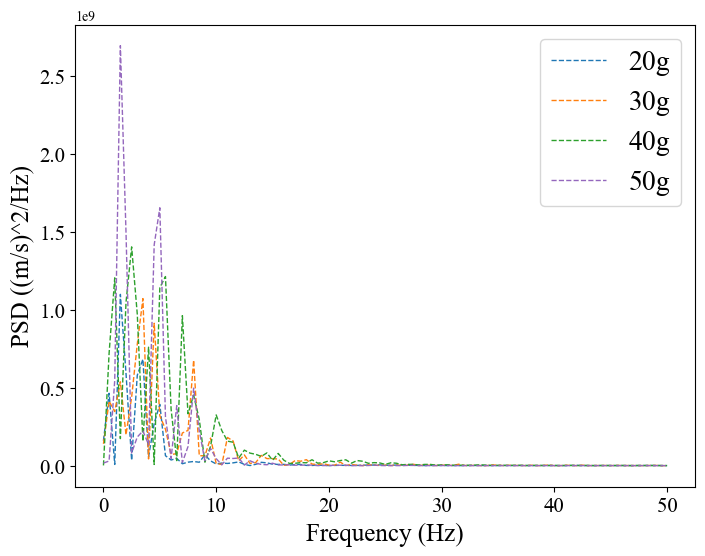

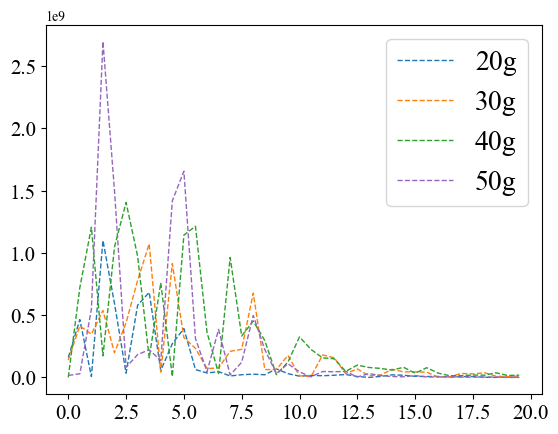

In [16]:
from scipy.signal import welch
plt.figure(figsize=(8, 6))
plt.grid(False)
plt.xlabel('Frequency (Hz)', fontsize=18)
plt.ylabel('PSD ((m/s)^2/Hz)', fontsize=18)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
def welchData(UV_xt, PhiU, k=0, linestyle='-', linewidth=1, c='b', iffeature=0, label='input label'):
    time_pattern = np.dot(UV_xt.T, PhiU[:, k])
    fre, psd = welch(time_pattern, fs=100, nperseg=200)
    if iffeature:
        plt.plot(fre[0:40], psd[0:40], linewidth=linewidth, linestyle=linestyle, color=c, label=label)
    else:
        plt.plot(fre, psd, linewidth=linewidth, linestyle=linestyle, color=c, label=label)
    
# frequencies, psd = welch(U0x_60g, fs=100, nperseg=200)
# time_pattern = np.dot(UV_xt_20g.T, PhiU_20g[:, 0])

welchData(R1.data_prepare()[0], R1.PhiU_pod[0], 0, '--', c=colors[0], label = '20g')
welchData(R2.data_prepare()[0], R2.PhiU_pod[0], 0, '--', c=colors[1], label = '30g')
welchData(R3.data_prepare()[0], R3.PhiU_pod[0], 0, '--', c=colors[2], label = '40g')
welchData(R4.data_prepare()[0], R4.PhiU_pod[0], 0, '--', c=colors[3], label = '50g')
legend3 = plt.legend(fontsize=20,
                     handler_map={plt.Line2D: HandlerLine2D(update_func=updateline)})
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('results/plot/acc/new_PODPSD.png', dpi=300)
plt.show()

welchData(R1.data_prepare()[0], R1.PhiU_pod[0], 0, '--', c=colors[0],label = '20g', iffeature=1)
welchData(R2.data_prepare()[0], R2.PhiU_pod[0], 0, '--', c=colors[1],label = '30g', iffeature=1)
welchData(R3.data_prepare()[0], R3.PhiU_pod[0], 0, '--', c=colors[2],label = '40g', iffeature=1)
welchData(R4.data_prepare()[0], R4.PhiU_pod[0], 0, '--', c=colors[3],label = '50g', iffeature=1)
legend3 = plt.legend(fontsize=20,
                     handler_map={plt.Line2D: HandlerLine2D(update_func=updateline)})
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('results/plot/acc/new_PODPSD_feature.png', dpi=300)
plt.show()

In [21]:
R4_0 = R4
R4 = RamMix('dataset/0306/glyS60gf40F70/ascii')

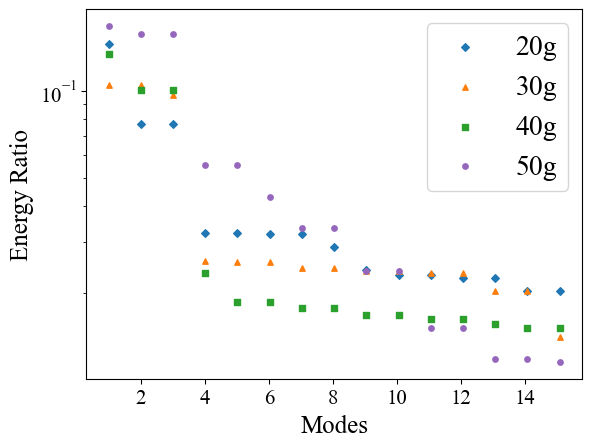

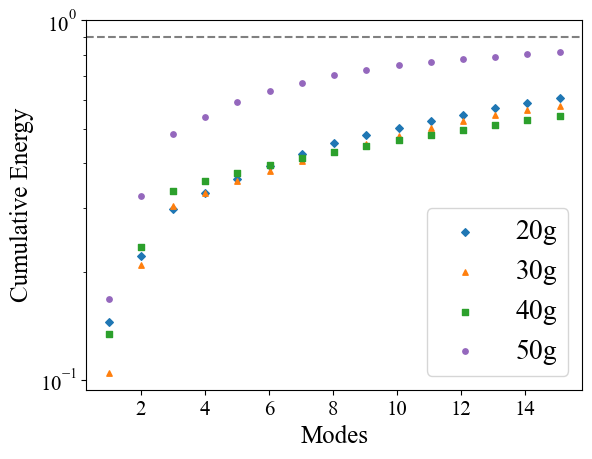

In [24]:
E_50g = R4.Energy[0] / np.sum(R4.Energy[0]) 
cum_E_50g = np.cumsum(E_50g) 

E_40g = R3.Energy[0] / np.sum(R3.Energy[0]) 
cum_E_40g = np.cumsum(E_40g) 

E_30g = R2.Energy[0] / np.sum(R2.Energy[0]) 
cum_E_30g = np.cumsum(E_30g) 

E_20g = R1.Energy[0] / np.sum(R1.Energy[0]) 
cum_E_20g = np.cumsum(E_20g) 

modes = np.linspace(0, len(E_50g), len(E_50g))
fig = plt.figure()
k = 15
plt.scatter(modes[0:k]+1, E_20g[0:k], s=15, marker='D', color=colors[0], label = '20g')
plt.scatter(modes[0:k]+1, E_30g[0:k], s=15, marker='^', color=colors[1], label = '30g')
plt.scatter(modes[0:k]+1, E_40g[0:k], s=15, marker='s', color=colors[2], label = '40g')
plt.scatter(modes[0:k]+1, E_50g[0:k], s=15, marker='o', color=colors[3], label = '50g')

plt.xlabel('Modes', fontsize=18)
plt.ylabel('Energy Ratio', fontsize=18)
legend4 = plt.legend(fontsize=20,
                     handler_map={plt.Line2D: HandlerLine2D(update_func=updateline)})

plt.yscale('log')
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("results/plot/acc/new_normalizedEnergyRatio_dmd"+str(k)+"th.png", dpi=300)
plt.show()

fig = plt.figure()

plt.scatter(modes[0:k]+1, cum_E_20g[0:k], s=15, marker='D', color=colors[0], label = '20g')
plt.scatter(modes[0:k]+1, cum_E_30g[0:k], s=15, marker='^', color=colors[1], label = '30g')
plt.scatter(modes[0:k]+1, cum_E_40g[0:k], s=15, marker='s', color=colors[2], label = '40g')
plt.scatter(modes[0:k]+1, cum_E_50g[0:k], s=15, marker='o', color=colors[3], label = '50g')
# 在 x = 0.99 处画一条虚线
plt.axhline(y=0.90, color='grey', linestyle='--')
plt.yscale('log')

plt.xlabel('Modes', fontsize=18)
plt.ylabel('Cumulative Energy', fontsize=18)
legend4 = plt.legend(fontsize=20,
                     handler_map={plt.Line2D: HandlerLine2D(update_func=updateline)})
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.savefig("results/plot/acc/new_normalizedEnergyDistribution_dmd"+str(k)+"th.png", dpi=300)
plt.show()

In [11]:
def setpltlim(wa):
    rangex = np.nanmax(np.real(wa)) - np.nanmin(np.real(wa))
    rangey = np.nanmax(np.imag(wa) / (2 * np.pi)) - np.nanmin(np.imag(wa)) / (2 * np.pi)
    plt.xlim(np.nanmin(np.real(wa)) - 0.1 * rangex, np.nanmax(np.real(wa)) + 0.1 * rangex)
    plt.ylim(np.nanmin(np.imag(wa)) / (2 * np.pi) - 0.1 * rangey, np.nanmax(np.imag(wa) / (2 * np.pi)) + 0.1 * rangey) 
    plt.show()
    
def getPositiveData(param1, param2):
    k = np.where(param1 >= 0)[0]
    return param1[k], param2[k], k
    
def plotFreqVsAttenuation(wa, Energy):
    # 增加一个极小的数防止计算过程出现inf
    param1, param2, k = getPositiveData(
                                     np.imag(wa) / (2 * np.pi),
                                     np.real(wa))
    plt.scatter(param1, param2,
                s=10,
                c=Energy[k],
                cmap='viridis',
                alpha=0.6)
    plt.ylabel('AttenuationRatio', fontsize=20)
    plt.xlabel('Frequency (Hz)', fontsize=20)
    plt.rcParams['font.sans-serif'] = ['Times New Roman']
    cbar = plt.colorbar()
#     cbar.set_ticks([Energy[k].max(), Energy[k].min()])
#     cbar.set_ticklabels([Energy[k].min(), Energy[k].max()])


def plotFreqVsEnergyPercent(wa, Energy, positive=0):
    # 准备数据
    categories = np.imag(wa) / (2 * np.pi)
    values = Energy
    colors = ['blue']  # 柱子的颜色
    edge_colors = ['white'] * len(categories)  # 柱子边框的颜色
    plt.xlabel('Frequency (Hz)', fontsize=20)
    plt.ylabel('Energy (%)', fontsize=20)
    plt.rcParams['font.sans-serif'] = ['Times New Roman']
    # 增加一个极小的数防止计算过程出现inf
    if positive:
        # 找到大于等于0的频率部分的索引
        k = np.where(categories >= 0)[0]
        plt.bar(categories[k], values[k], color=colors, edgecolor=edge_colors, width=0.5)
    else:    
    # 创建柱状图
        plt.bar(categories, values, color=colors, edgecolor=edge_colors, width=0.5)

<Figure size 640x480 with 0 Axes>

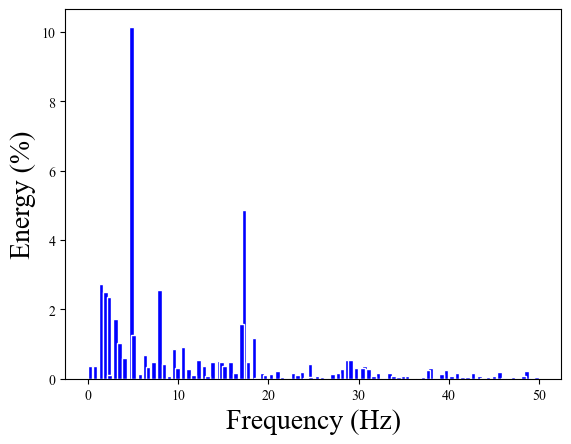

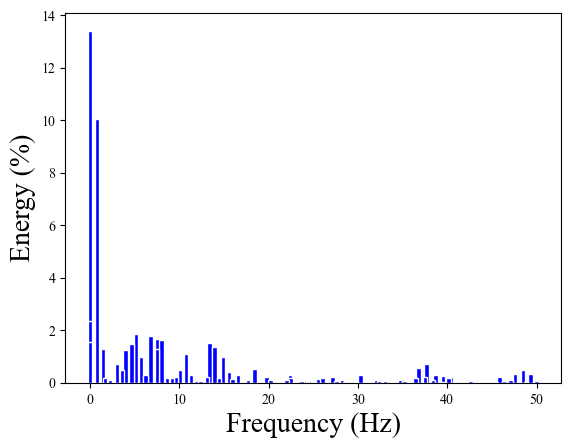

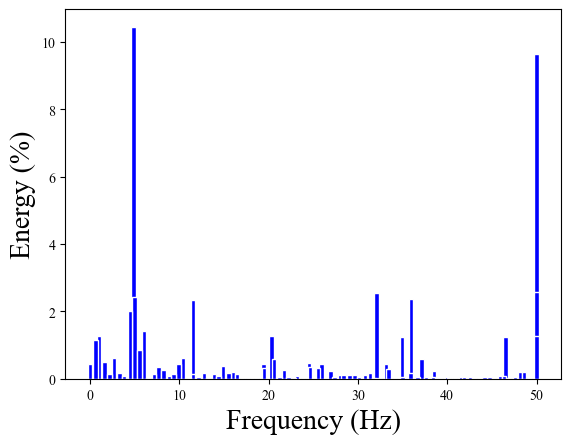

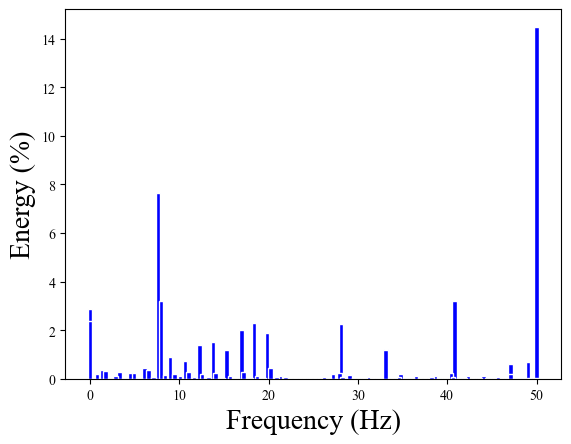

In [12]:
fig2 = plt.figure(2)
# 图2 绘制频率和衰减图
Fs = 1 / 0.01
wa50g = np.log(np.sum(R4.Dd[0], axis=1)) * Fs
wa40g = np.log(np.sum(R3.Dd[0], axis=1)) * Fs
wa30g = np.log(np.sum(R2.Dd[0], axis=1)) * Fs
wa20g = np.log(np.sum(R1.Dd[0], axis=1)) * Fs

fig3 = plt.figure(3)
plotFreqVsEnergyPercent(wa50g, E_50g*100, positive=1)
plt.savefig("results/plot/acc/new_freqVsEnergyPercent_dmd50g.png", dpi=300)
plt.show()
plotFreqVsEnergyPercent(wa40g, E_40g*100, positive=1)
plt.savefig("results/plot/acc/new_freqVsEnergyPercent_dmd40g.png", dpi=300)
plt.show()
plotFreqVsEnergyPercent(wa30g, E_30g*100, positive=1)
plt.savefig("results/plot/acc/new_freqVsEnergyPercent_dmd30g.png", dpi=300)
plt.show()
plotFreqVsEnergyPercent(wa20g, E_20g*100, positive=1)
plt.savefig("results/plot/acc/new_freqVsEnergyPercent_dmd20g.png", dpi=300)
plt.show()

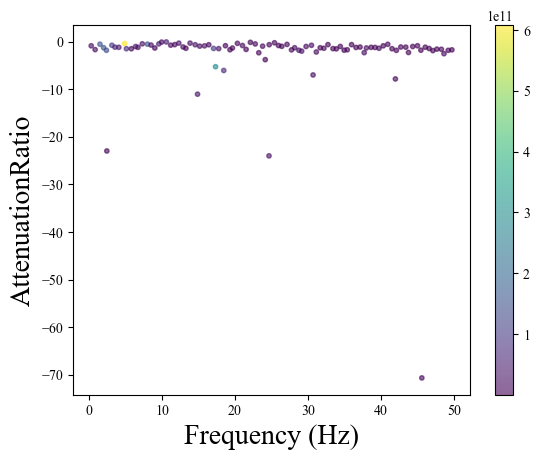

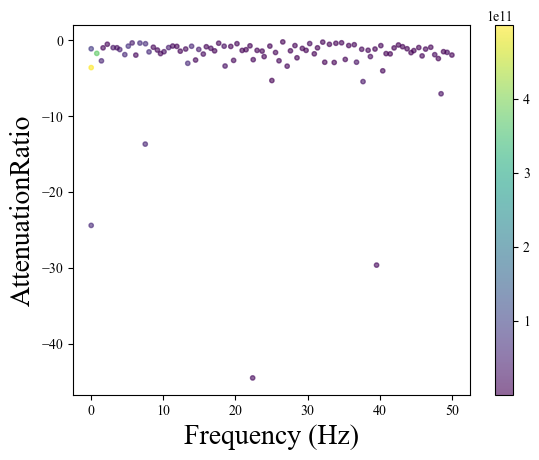

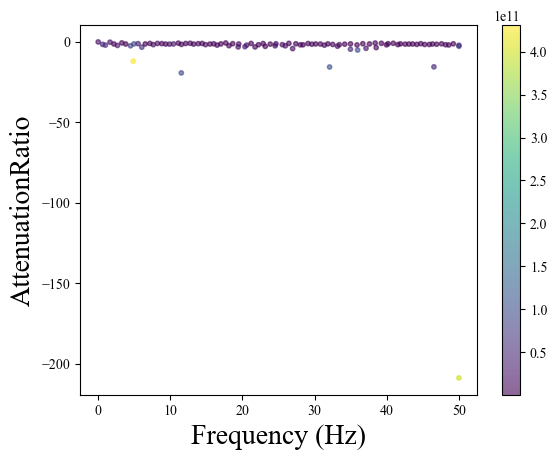

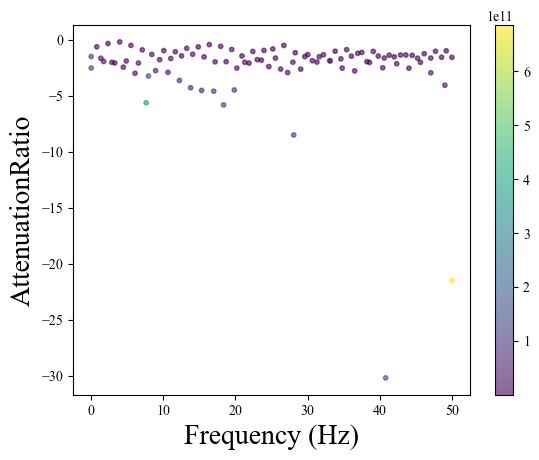

In [13]:
fig = plt.figure(4)
plotFreqVsAttenuation(wa50g, R4.Energy[0])
plt.savefig("results/plot/acc/new_freqVsAttenuation_dmd50g.png", dpi=300)
plt.show()
plotFreqVsAttenuation(wa40g, R3.Energy[0])
plt.savefig("results/plot/acc/new_freqVsAttenuation_dmd40g.png", dpi=300)
plt.show()
plotFreqVsAttenuation(wa30g, R2.Energy[0])
plt.savefig("results/plot/acc/new_freqVsAttenuation_dmd30g.png", dpi=300)
plt.show()
plotFreqVsAttenuation(wa20g, R1.Energy[0])
plt.savefig("results/plot/acc/new_freqVsAttenuation_dmd20g.png", dpi=300)
plt.show()